In [1]:
import re
import os
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(2)
epochs = 64
batch_size = 2048
model_name = 'chinese_roberta_wwm_large_ext_L-24_H-1024_A-16'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/ai-cup-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

44334
44334


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

28373 28373
7094 7094
8867 8867


In [10]:
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import TransformerEmbedding
from keras_radam import RAdam
kashgari.config.use_cudnn_cell = True

embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)
vocab_path = os.path.join(embedding_path, 'vocab.txt')
config_path = os.path.join(embedding_path, 'bert_config.json')
checkpoint_path = os.path.join(embedding_path, 'bert_model.ckpt')
embedding = TransformerEmbedding(vocab_path, 
                                 config_path, 
                                 checkpoint_path,
                                 bert_type='bert',
                                 sequence_length='auto',
                                 trainable=True,
                                 task='kashgari.LABELING',
                                )

model = BiLSTM_CRF_Model(embedding)
# model.build_model(train_x, train_y)
# model.compile_model(optimizer=RAdam(lr=3e-5))
# hyper = model.default_hyper_parameters()
# print(hyper)

2020-12-23 13:25:16,658 [DEBUG] kashgari - ------------------------------------------------
2020-12-23 13:25:16,659 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-23 13:25:16,659 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_config.json
2020-12-23 13:25:16,660 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/vocab.txt
2020-12-23 13:25:16,660 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_model.ckpt
2020-12-23 13:25:16,661 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]'

In [11]:
%%time
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

Preparing text vocab dict: 100%|██████████| 7094/7094 [00:00<00:00, 290931.06it/s]
2020-12-23 13:25:16,796 [DEBUG] kashgari - --- Build vocab dict finished, Total: 1731 ---
2020-12-23 13:25:16,796 [DEBUG] kashgari - Top-10: ['[PAD]', '[UNK]', '[CLS]', '[SEP]', '：', '，', '師', '是', '民', '眾']
Preparing text vocab dict: 100%|██████████| 7094/7094 [00:00<00:00, 392015.82it/s]
2020-12-23 13:25:16,890 [DEBUG] kashgari - --- Build vocab dict finished, Total: 28 ---
2020-12-23 13:25:16,891 [DEBUG] kashgari - Top-10: ['[PAD]', 'O', 'I-time', 'B-time', 'I-med_exam', 'I-name', 'B-med_exam', 'I-location', 'I-money', 'B-name']
Calculating sequence length: 100%|██████████| 7094/7094 [00:00<00:00, 1379945.86it/s]
2020-12-23 13:25:23,895 [DEBUG] kashgari - Calculated sequence length = 42
2020-12-23 13:25:26,165 [DEBUG] kashgari - fit input shape: (2, 2048, 42)
2020-12-23 13:25:26,166 [DEBUG] kashgari - fit input shape: (2048, 42)


Epoch 1/64
13/13 [==============================] - 143s 11s/step - loss: 3.8081 - accuracy: 0.8503 - val_loss: 37.0148 - val_accuracy: 0.9674
Epoch 2/64
13/13 [==============================] - 155s 12s/step - loss: 1.1030 - accuracy: 0.9680 - val_loss: 37.0472 - val_accuracy: 0.9692
Epoch 3/64
13/13 [==============================] - 154s 12s/step - loss: 0.7911 - accuracy: 0.9721 - val_loss: 36.8715 - val_accuracy: 0.9750
Epoch 4/64
13/13 [==============================] - 153s 12s/step - loss: 0.6287 - accuracy: 0.9760 - val_loss: 36.9231 - val_accuracy: 0.9780
Epoch 5/64
13/13 [==============================] - 154s 12s/step - loss: 0.5437 - accuracy: 0.9781 - val_loss: 36.7053 - val_accuracy: 0.9798
Epoch 6/64
13/13 [==============================] - 155s 12s/step - loss: 0.4867 - accuracy: 0.9797 - val_loss: 36.6653 - val_accuracy: 0.9804
Epoch 7/64
13/13 [==============================] - 155s 12s/step - loss: 0.4325 - accuracy: 0.9809 - val_loss: 36.6349 - val_accuracy: 0.9813

Epoch 58/64
13/13 [==============================] - 139s 11s/step - loss: 0.0501 - accuracy: 0.9972 - val_loss: 35.7050 - val_accuracy: 0.9921
Epoch 59/64
13/13 [==============================] - 120s 9s/step - loss: 0.0461 - accuracy: 0.9976 - val_loss: 35.7054 - val_accuracy: 0.9930
Epoch 60/64
13/13 [==============================] - 122s 9s/step - loss: 0.0446 - accuracy: 0.9975 - val_loss: 35.8339 - val_accuracy: 0.9931
Epoch 61/64
13/13 [==============================] - 144s 11s/step - loss: 0.0440 - accuracy: 0.9976 - val_loss: 35.6726 - val_accuracy: 0.9932
Epoch 62/64
13/13 [==============================] - 149s 11s/step - loss: 0.0414 - accuracy: 0.9978 - val_loss: 35.6354 - val_accuracy: 0.9930
Epoch 63/64
13/13 [==============================] - 151s 12s/step - loss: 0.0424 - accuracy: 0.9976 - val_loss: 35.6470 - val_accuracy: 0.9928
Epoch 64/64
13/13 [==============================] - 150s 12s/step - loss: 0.0408 - accuracy: 0.9978 - val_loss: 35.6158 - val_accuracy: 0

In [12]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-23 16:22:53,500 [INFO] kashgari - model saved to /home/Danny/ai-cup-2020/danny/roberta/model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16_epoch_64_batch_2048


'/home/Danny/ai-cup-2020/danny/roberta/model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16_epoch_64_batch_2048'

In [13]:
from kashgari.utils import load_model
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model = load_model(model_path)
model.evaluate(test_x, test_y)

/home/Danny/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The 'load_model' function is deprecated, use 'XX_Model.load_model' instead
  This is separate from the ipykernel package so we can avoid doing imports until
2020-12-23 16:22:53,666 [DEBUG] kashgari - ------------------------------------------------
2020-12-23 16:22:53,671 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-23 16:22:53,675 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_config.json
2020-12-23 16:22:53,676 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/vocab.txt
2020-12-23 16:22:53,676 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/chinese_roberta_wwm_large_ext_L-24_H-1024_A-16/bert_model.ckpt
2020-12-23 16:22:53,676 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unuse

278/278 [==============================] - 297s 1s/step


2020-12-23 16:28:18,473 [DEBUG] kashgari - predict output: (8867, 295)
2020-12-23 16:28:18,474 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

          time     0.7682    0.8488    0.8065       820
      location     0.8846    0.8364    0.8598       110
      med_exam     0.7466    0.9008    0.8165       121
         money     0.8511    0.8333    0.8421        48
          name     0.8229    0.8229    0.8229        96
        family     0.7500    0.6667    0.7059         9
            ID     0.0000    0.0000    0.0000         6
       contact     0.6667    0.5000    0.5714         4
    profession     0.2500    0.1250    0.1667         8
clinical_event     0.0000    0.0000    0.0000         3
        others     0.0000    0.0000    0.0000         1

     micro avg     0.7771    0.8361    0.8055      1226
     macro avg     0.7739    0.8361    0.8027      1226



{'detail': {'time': {'precision': 0.7682119205298014,
   'recall': 0.848780487804878,
   'f1-score': 0.8064889918887601,
   'support': 820},
  'location': {'precision': 0.8846153846153846,
   'recall': 0.8363636363636363,
   'f1-score': 0.8598130841121494,
   'support': 110},
  'med_exam': {'precision': 0.7465753424657534,
   'recall': 0.9008264462809917,
   'f1-score': 0.8164794007490637,
   'support': 121},
  'money': {'precision': 0.851063829787234,
   'recall': 0.8333333333333334,
   'f1-score': 0.8421052631578947,
   'support': 48},
  'name': {'precision': 0.8229166666666666,
   'recall': 0.8229166666666666,
   'f1-score': 0.8229166666666666,
   'support': 96},
  'family': {'precision': 0.75,
   'recall': 0.6666666666666666,
   'f1-score': 0.7058823529411765,
   'support': 9},
  'ID': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0, 'support': 6},
  'contact': {'precision': 0.6666666666666666,
   'recall': 0.5,
   'f1-score': 0.5714285714285715,
   'support': 4},
  'profession': {

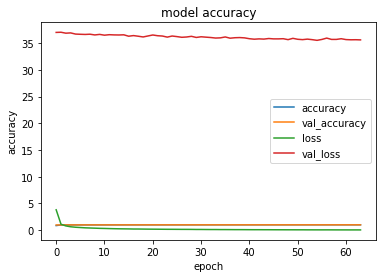

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [15]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [16]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [17]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [18]:
df = predicting_txt_to_dataframe('/home/Danny/ai-cup-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-23 16:28:19,609 [DEBUG] kashgari - predict seq_length: None, input: (2, 46, 34)


2/2 [==============================] - 0s 42ms/step


2020-12-23 16:28:26,424 [DEBUG] kashgari - predict output: (46, 34)
2020-12-23 16:28:26,425 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:28:26,427 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 41)


3/3 [==============================] - 0s 93ms/step


2020-12-23 16:28:33,217 [DEBUG] kashgari - predict output: (88, 41)
2020-12-23 16:28:33,218 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:28:33,222 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 163)


3/3 [==============================] - 1s 327ms/step


2020-12-23 16:28:40,908 [DEBUG] kashgari - predict output: (88, 163)
2020-12-23 16:28:40,909 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]]
2020-12-23 16:28:40,911 [DEBUG] kashgari - predict seq_length: None, input: (2, 41, 86)


2/2 [==============================] - 0s 64ms/step


2020-12-23 16:28:48,101 [DEBUG] kashgari - predict output: (41, 86)
2020-12-23 16:28:48,102 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:28:48,103 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 90)


2/2 [==============================] - 0s 50ms/step


2020-12-23 16:28:54,686 [DEBUG] kashgari - predict output: (39, 90)
2020-12-23 16:28:54,687 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:28:54,691 [DEBUG] kashgari - predict seq_length: None, input: (2, 157, 57)


5/5 [==============================] - 1s 156ms/step


2020-12-23 16:29:02,276 [DEBUG] kashgari - predict output: (157, 57)
2020-12-23 16:29:02,276 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-23 16:29:02,280 [DEBUG] kashgari - predict seq_length: None, input: (2, 174, 65)


6/6 [==============================] - 1s 167ms/step


2020-12-23 16:29:09,750 [DEBUG] kashgari - predict output: (174, 65)
2020-12-23 16:29:09,752 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 6 4 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:09,754 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 57)


3/3 [==============================] - 0s 110ms/step


2020-12-23 16:29:10,316 [DEBUG] kashgari - predict output: (83, 57)
2020-12-23 16:29:10,317 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:10,320 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 53)


4/4 [==============================] - 0s 107ms/step


2020-12-23 16:29:18,702 [DEBUG] kashgari - predict output: (98, 53)
2020-12-23 16:29:18,702 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  4  4  4]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 11 11 11]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:29:18,706 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 84)


7/7 [==============================] - 1s 208ms/step


2020-12-23 16:29:27,640 [DEBUG] kashgari - predict output: (193, 84)
2020-12-23 16:29:27,640 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:27,643 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 84)


4/4 [==============================] - 1s 157ms/step


2020-12-23 16:29:28,584 [DEBUG] kashgari - predict output: (98, 84)
2020-12-23 16:29:28,586 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:28,593 [DEBUG] kashgari - predict seq_length: None, input: (2, 362, 94)


12/12 [==============================] - 3s 268ms/step


2020-12-23 16:29:38,762 [DEBUG] kashgari - predict output: (362, 94)
2020-12-23 16:29:38,763 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:38,765 [DEBUG] kashgari - predict seq_length: None, input: (2, 29, 34)


1/1 [==============================] - 0s 840us/step


2020-12-23 16:29:38,914 [DEBUG] kashgari - predict output: (29, 34)
2020-12-23 16:29:38,917 [DEBUG] kashgari - predict output argmax: [[ 0  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1  1  1]
 [ 0  1  1

4/4 [==============================] - 0s 100ms/step


2020-12-23 16:29:46,645 [DEBUG] kashgari - predict output: (111, 43)
2020-12-23 16:29:46,646 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:29:46,648 [DEBUG] kashgari - predict seq_length: None, input: (2, 101, 54)


4/4 [==============================] - 0s 114ms/step


2020-12-23 16:29:53,673 [DEBUG] kashgari - predict output: (101, 54)
2020-12-23 16:29:53,674 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:53,675 [DEBUG] kashgari - predict seq_length: None, input: (2, 51, 41)


2/2 [==============================] - 0s 54ms/step


2020-12-23 16:29:53,954 [DEBUG] kashgari - predict output: (51, 41)
2020-12-23 16:29:53,955 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:29:53,957 [DEBUG] kashgari - predict seq_length: None, input: (2, 51, 151)


2/2 [==============================] - 0s 162ms/step


2020-12-23 16:30:02,117 [DEBUG] kashgari - predict output: (51, 151)
2020-12-23 16:30:02,118 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:02,119 [DEBUG] kashgari - predict seq_length: None, input: (2, 60, 38)


2/2 [==============================] - 0s 67ms/step


2020-12-23 16:30:09,345 [DEBUG] kashgari - predict output: (60, 38)
2020-12-23 16:30:09,346 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:09,351 [DEBUG] kashgari - predict seq_length: None, input: (2, 150, 48)


5/5 [==============================] - 1s 123ms/step


2020-12-23 16:30:16,779 [DEBUG] kashgari - predict output: (150, 48)
2020-12-23 16:30:16,780 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:16,784 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 75)


5/5 [==============================] - 1s 163ms/step


2020-12-23 16:30:24,206 [DEBUG] kashgari - predict output: (133, 75)
2020-12-23 16:30:24,207 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:24,209 [DEBUG] kashgari - predict seq_length: None, input: (2, 108, 42)


4/4 [==============================] - 0s 92ms/step


2020-12-23 16:30:31,639 [DEBUG] kashgari - predict output: (108, 42)
2020-12-23 16:30:31,640 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 7 7 7]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:31,642 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 63)


2/2 [==============================] - 0s 92ms/step


2020-12-23 16:30:38,959 [DEBUG] kashgari - predict output: (59, 63)
2020-12-23 16:30:38,960 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:38,962 [DEBUG] kashgari - predict seq_length: None, input: (2, 47, 75)


2/2 [==============================] - 0s 70ms/step


2020-12-23 16:30:39,376 [DEBUG] kashgari - predict output: (47, 75)
2020-12-23 16:30:39,377 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:39,381 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 91)


5/5 [==============================] - 1s 223ms/step


2020-12-23 16:30:47,142 [DEBUG] kashgari - predict output: (148, 91)
2020-12-23 16:30:47,143 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:47,145 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 37)


2/2 [==============================] - 0s 38ms/step


2020-12-23 16:30:54,975 [DEBUG] kashgari - predict output: (39, 37)
2020-12-23 16:30:54,977 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:30:54,979 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 33)


2/2 [==============================] - 0s 56ms/step


2020-12-23 16:31:01,706 [DEBUG] kashgari - predict output: (57, 33)
2020-12-23 16:31:01,707 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:01,710 [DEBUG] kashgari - predict seq_length: None, input: (2, 91, 111)


3/3 [==============================] - 1s 224ms/step


2020-12-23 16:31:09,076 [DEBUG] kashgari - predict output: (91, 111)
2020-12-23 16:31:09,077 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:09,080 [DEBUG] kashgari - predict seq_length: None, input: (2, 86, 73)


3/3 [==============================] - 0s 141ms/step


2020-12-23 16:31:16,121 [DEBUG] kashgari - predict output: (86, 73)
2020-12-23 16:31:16,122 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:16,124 [DEBUG] kashgari - predict seq_length: None, input: (2, 156, 49)


5/5 [==============================] - 1s 132ms/step


2020-12-23 16:31:23,319 [DEBUG] kashgari - predict output: (156, 49)
2020-12-23 16:31:23,320 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:23,322 [DEBUG] kashgari - predict seq_length: None, input: (2, 68, 37)


3/3 [==============================] - 0s 62ms/step


2020-12-23 16:31:23,670 [DEBUG] kashgari - predict output: (68, 37)
2020-12-23 16:31:23,671 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:23,674 [DEBUG] kashgari - predict seq_length: None, input: (2, 90, 56)


3/3 [==============================] - 0s 120ms/step


2020-12-23 16:31:30,609 [DEBUG] kashgari - predict output: (90, 56)
2020-12-23 16:31:30,610 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:30,612 [DEBUG] kashgari - predict seq_length: None, input: (2, 147, 40)


5/5 [==============================] - 1s 109ms/step


2020-12-23 16:31:37,988 [DEBUG] kashgari - predict output: (147, 40)
2020-12-23 16:31:37,989 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:37,991 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 54)


3/3 [==============================] - 0s 103ms/step


2020-12-23 16:31:38,518 [DEBUG] kashgari - predict output: (82, 54)
2020-12-23 16:31:38,519 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:38,521 [DEBUG] kashgari - predict seq_length: None, input: (2, 42, 45)


2/2 [==============================] - 0s 41ms/step


2020-12-23 16:31:45,138 [DEBUG] kashgari - predict output: (42, 45)
2020-12-23 16:31:45,139 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:45,141 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 43)


2/2 [==============================] - 0s 60ms/step


2020-12-23 16:31:45,438 [DEBUG] kashgari - predict output: (56, 43)
2020-12-23 16:31:45,439 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:45,443 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 31)


6/6 [==============================] - 1s 89ms/step


2020-12-23 16:31:54,757 [DEBUG] kashgari - predict output: (163, 31)
2020-12-23 16:31:54,758 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:54,760 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 38)


3/3 [==============================] - 0s 77ms/step


2020-12-23 16:31:59,323 [DEBUG] kashgari - predict output: (96, 38)
2020-12-23 16:31:59,324 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:59,326 [DEBUG] kashgari - predict seq_length: None, input: (2, 42, 54)


2/2 [==============================] - 0s 47ms/step


2020-12-23 16:31:59,632 [DEBUG] kashgari - predict output: (42, 54)
2020-12-23 16:31:59,633 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:31:59,634 [DEBUG] kashgari - predict seq_length: None, input: (2, 54, 81)


2/2 [==============================] - 0s 100ms/step


2020-12-23 16:32:06,885 [DEBUG] kashgari - predict output: (54, 81)
2020-12-23 16:32:06,886 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:32:06,888 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 78)


4/4 [==============================] - 1s 171ms/step


2020-12-23 16:32:14,768 [DEBUG] kashgari - predict output: (115, 78)
2020-12-23 16:32:14,769 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:14,771 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 36)


2/2 [==============================] - 0s 26ms/step


2020-12-23 16:32:21,349 [DEBUG] kashgari - predict output: (39, 36)
2020-12-23 16:32:21,350 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:21,355 [DEBUG] kashgari - predict seq_length: None, input: (2, 233, 62)


8/8 [==============================] - 1s 165ms/step


2020-12-23 16:32:29,281 [DEBUG] kashgari - predict output: (233, 62)
2020-12-23 16:32:29,282 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:29,284 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 50)


4/4 [==============================] - 0s 117ms/step


2020-12-23 16:32:36,274 [DEBUG] kashgari - predict output: (115, 50)
2020-12-23 16:32:36,275 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:36,277 [DEBUG] kashgari - predict seq_length: None, input: (2, 68, 59)


3/3 [==============================] - 1s 178ms/step


2020-12-23 16:32:46,013 [DEBUG] kashgari - predict output: (68, 59)
2020-12-23 16:32:46,018 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 7 7 7]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:46,024 [DEBUG] kashgari - predict seq_length: None, input: (2, 81, 53)


3/3 [==============================] - 1s 289ms/step


2020-12-23 16:32:47,500 [DEBUG] kashgari - predict output: (81, 53)
2020-12-23 16:32:47,501 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:47,511 [DEBUG] kashgari - predict seq_length: None, input: (2, 225, 75)


8/8 [==============================] - 3s 416ms/step


2020-12-23 16:32:51,528 [DEBUG] kashgari - predict output: (225, 75)
2020-12-23 16:32:51,531 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:32:51,538 [DEBUG] kashgari - predict seq_length: None, input: (2, 30, 39)


1/1 [==============================] - 0s 1ms/step


2020-12-23 16:33:02,902 [DEBUG] kashgari - predict output: (30, 39)
2020-12-23 16:33:02,903 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:33:02,905 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 28)


3/3 [==============================] - 0s 78ms/step


2020-12-23 16:33:09,638 [DEBUG] kashgari - predict output: (95, 28)
2020-12-23 16:33:09,638 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:09,641 [DEBUG] kashgari - predict seq_length: None, input: (2, 128, 99)


4/4 [==============================] - 1s 218ms/step


2020-12-23 16:33:17,018 [DEBUG] kashgari - predict output: (128, 99)
2020-12-23 16:33:17,019 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:17,021 [DEBUG] kashgari - predict seq_length: None, input: (2, 83, 95)


3/3 [==============================] - 1s 169ms/step


2020-12-23 16:33:24,319 [DEBUG] kashgari - predict output: (83, 95)
2020-12-23 16:33:24,320 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:33:24,323 [DEBUG] kashgari - predict seq_length: None, input: (2, 115, 84)


4/4 [==============================] - 1s 177ms/step


2020-12-23 16:33:25,332 [DEBUG] kashgari - predict output: (115, 84)
2020-12-23 16:33:25,333 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:25,336 [DEBUG] kashgari - predict seq_length: None, input: (2, 137, 65)


5/5 [==============================] - 1s 150ms/step


2020-12-23 16:33:26,333 [DEBUG] kashgari - predict output: (137, 65)
2020-12-23 16:33:26,334 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:33:26,336 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 56)


2/2 [==============================] - 0s 71ms/step


2020-12-23 16:33:26,696 [DEBUG] kashgari - predict output: (53, 56)
2020-12-23 16:33:26,697 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:26,701 [DEBUG] kashgari - predict seq_length: None, input: (2, 161, 76)


6/6 [==============================] - 1s 176ms/step


2020-12-23 16:33:34,481 [DEBUG] kashgari - predict output: (161, 76)
2020-12-23 16:33:34,481 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:34,484 [DEBUG] kashgari - predict seq_length: None, input: (2, 137, 35)


5/5 [==============================] - 0s 88ms/step


2020-12-23 16:33:41,501 [DEBUG] kashgari - predict output: (137, 35)
2020-12-23 16:33:41,502 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:41,506 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 73)


4/4 [==============================] - 1s 138ms/step


2020-12-23 16:33:42,325 [DEBUG] kashgari - predict output: (98, 73)
2020-12-23 16:33:42,326 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:42,329 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 26)


5/5 [==============================] - 0s 87ms/step


2020-12-23 16:33:49,313 [DEBUG] kashgari - predict output: (154, 26)
2020-12-23 16:33:49,314 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:49,316 [DEBUG] kashgari - predict seq_length: None, input: (2, 69, 41)


3/3 [==============================] - 0s 68ms/step


2020-12-23 16:33:49,691 [DEBUG] kashgari - predict output: (69, 41)
2020-12-23 16:33:49,692 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:49,696 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 61)


4/4 [==============================] - 1s 145ms/step


2020-12-23 16:33:56,866 [DEBUG] kashgari - predict output: (121, 61)
2020-12-23 16:33:56,867 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:56,870 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 31)


5/5 [==============================] - 0s 85ms/step


2020-12-23 16:33:57,443 [DEBUG] kashgari - predict output: (143, 31)
2020-12-23 16:33:57,444 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:33:57,448 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 66)


5/5 [==============================] - 1s 155ms/step


2020-12-23 16:34:05,264 [DEBUG] kashgari - predict output: (139, 66)
2020-12-23 16:34:05,264 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:05,267 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 98ms/step


2020-12-23 16:34:05,925 [DEBUG] kashgari - predict output: (139, 38)
2020-12-23 16:34:05,925 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:05,930 [DEBUG] kashgari - predict seq_length: None, input: (2, 135, 55)


5/5 [==============================] - 1s 128ms/step


2020-12-23 16:34:13,178 [DEBUG] kashgari - predict output: (135, 55)
2020-12-23 16:34:13,179 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:13,181 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 77)


3/3 [==============================] - 0s 117ms/step


2020-12-23 16:34:20,249 [DEBUG] kashgari - predict output: (72, 77)
2020-12-23 16:34:20,250 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:20,252 [DEBUG] kashgari - predict seq_length: None, input: (2, 74, 57)


3/3 [==============================] - 0s 97ms/step


2020-12-23 16:34:20,770 [DEBUG] kashgari - predict output: (74, 57)
2020-12-23 16:34:20,771 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 4 4 4]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:20,774 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 36)


7/7 [==============================] - 1s 110ms/step


2020-12-23 16:34:21,710 [DEBUG] kashgari - predict output: (218, 36)
2020-12-23 16:34:21,711 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:21,714 [DEBUG] kashgari - predict seq_length: None, input: (2, 89, 47)


3/3 [==============================] - 0s 105ms/step


2020-12-23 16:34:28,964 [DEBUG] kashgari - predict output: (89, 47)
2020-12-23 16:34:28,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:28,969 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 115)


8/8 [==============================] - 3s 314ms/step


2020-12-23 16:34:38,467 [DEBUG] kashgari - predict output: (246, 115)
2020-12-23 16:34:38,468 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:38,472 [DEBUG] kashgari - predict seq_length: None, input: (2, 169, 56)


6/6 [==============================] - 1s 144ms/step


2020-12-23 16:34:39,562 [DEBUG] kashgari - predict output: (169, 56)
2020-12-23 16:34:39,563 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:39,566 [DEBUG] kashgari - predict seq_length: None, input: (2, 60, 62)


2/2 [==============================] - 0s 99ms/step


2020-12-23 16:34:40,005 [DEBUG] kashgari - predict output: (60, 62)
2020-12-23 16:34:40,006 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:40,010 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 163)


4/4 [==============================] - 1s 316ms/step


2020-12-23 16:34:41,840 [DEBUG] kashgari - predict output: (104, 163)
2020-12-23 16:34:41,841 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:41,844 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 57)


3/3 [==============================] - 0s 116ms/step


2020-12-23 16:34:46,646 [DEBUG] kashgari - predict output: (96, 57)
2020-12-23 16:34:46,646 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:46,649 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 42)


4/4 [==============================] - 0s 96ms/step


2020-12-23 16:34:47,213 [DEBUG] kashgari - predict output: (111, 42)
2020-12-23 16:34:47,213 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:47,218 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 61)


5/5 [==============================] - 1s 167ms/step


2020-12-23 16:34:48,299 [DEBUG] kashgari - predict output: (159, 61)
2020-12-23 16:34:48,300 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 2 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:48,302 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 38)


4/4 [==============================] - 0s 86ms/step


2020-12-23 16:34:48,817 [DEBUG] kashgari - predict output: (102, 38)
2020-12-23 16:34:48,818 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:48,822 [DEBUG] kashgari - predict seq_length: None, input: (2, 127, 46)


4/4 [==============================] - 0s 117ms/step


2020-12-23 16:34:56,341 [DEBUG] kashgari - predict output: (127, 46)
2020-12-23 16:34:56,342 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:34:56,346 [DEBUG] kashgari - predict seq_length: None, input: (2, 271, 83)


9/9 [==============================] - 2s 229ms/step


2020-12-23 16:35:07,685 [DEBUG] kashgari - predict output: (271, 83)
2020-12-23 16:35:07,686 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:07,689 [DEBUG] kashgari - predict seq_length: None, input: (2, 163, 53)


6/6 [==============================] - 1s 134ms/step


2020-12-23 16:35:08,710 [DEBUG] kashgari - predict output: (163, 53)
2020-12-23 16:35:08,712 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:08,715 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 27)


3/3 [==============================] - 0s 58ms/step


2020-12-23 16:35:15,652 [DEBUG] kashgari - predict output: (67, 27)
2020-12-23 16:35:15,652 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:15,655 [DEBUG] kashgari - predict seq_length: None, input: (2, 190, 56)


6/6 [==============================] - 1s 159ms/step


2020-12-23 16:35:16,833 [DEBUG] kashgari - predict output: (190, 56)
2020-12-23 16:35:16,834 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:16,838 [DEBUG] kashgari - predict seq_length: None, input: (2, 109, 53)


4/4 [==============================] - 0s 122ms/step


2020-12-23 16:35:17,546 [DEBUG] kashgari - predict output: (109, 53)
2020-12-23 16:35:17,547 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:17,549 [DEBUG] kashgari - predict seq_length: None, input: (2, 107, 104)


4/4 [==============================] - 1s 200ms/step


2020-12-23 16:35:25,037 [DEBUG] kashgari - predict output: (107, 104)
2020-12-23 16:35:25,038 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:25,040 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 30)


5/5 [==============================] - 0s 90ms/step


2020-12-23 16:35:31,968 [DEBUG] kashgari - predict output: (158, 30)
2020-12-23 16:35:31,969 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:31,973 [DEBUG] kashgari - predict seq_length: None, input: (2, 264, 121)


9/9 [==============================] - 3s 319ms/step


2020-12-23 16:35:41,601 [DEBUG] kashgari - predict output: (264, 121)
2020-12-23 16:35:41,602 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:41,605 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 110)


4/4 [==============================] - 1s 227ms/step


2020-12-23 16:35:49,222 [DEBUG] kashgari - predict output: (112, 110)
2020-12-23 16:35:49,223 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:49,226 [DEBUG] kashgari - predict seq_length: None, input: (2, 188, 95)


6/6 [==============================] - 2s 260ms/step


2020-12-23 16:35:51,148 [DEBUG] kashgari - predict output: (188, 95)
2020-12-23 16:35:51,149 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:51,151 [DEBUG] kashgari - predict seq_length: None, input: (2, 51, 48)


2/2 [==============================] - 0s 63ms/step


2020-12-23 16:35:51,472 [DEBUG] kashgari - predict output: (51, 48)
2020-12-23 16:35:51,472 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:51,474 [DEBUG] kashgari - predict seq_length: None, input: (2, 55, 50)


2/2 [==============================] - 0s 70ms/step


2020-12-23 16:35:51,829 [DEBUG] kashgari - predict output: (55, 50)
2020-12-23 16:35:51,831 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:51,835 [DEBUG] kashgari - predict seq_length: None, input: (2, 128, 81)


4/4 [==============================] - 1s 181ms/step


2020-12-23 16:35:57,106 [DEBUG] kashgari - predict output: (128, 81)
2020-12-23 16:35:57,107 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:35:57,110 [DEBUG] kashgari - predict seq_length: None, input: (2, 90, 51)


3/3 [==============================] - 0s 112ms/step


2020-12-23 16:36:04,754 [DEBUG] kashgari - predict output: (90, 51)
2020-12-23 16:36:04,755 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:04,759 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 47)


5/5 [==============================] - 1s 109ms/step


2020-12-23 16:36:05,499 [DEBUG] kashgari - predict output: (129, 47)
2020-12-23 16:36:05,500 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 17 17 17]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:36:05,503 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 46)


3/3 [==============================] - 0s 102ms/step


2020-12-23 16:36:06,002 [DEBUG] kashgari - predict output: (93, 46)
2020-12-23 16:36:06,003 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:06,008 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 31)


6/6 [==============================] - 1s 93ms/step


2020-12-23 16:36:06,715 [DEBUG] kashgari - predict output: (176, 31)
2020-12-23 16:36:06,716 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:06,718 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 45)


3/3 [==============================] - 0s 89ms/step


2020-12-23 16:36:07,173 [DEBUG] kashgari - predict output: (78, 45)
2020-12-23 16:36:07,174 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:07,178 [DEBUG] kashgari - predict seq_length: None, input: (2, 230, 61)


8/8 [==============================] - 1s 168ms/step


2020-12-23 16:36:08,770 [DEBUG] kashgari - predict output: (230, 61)
2020-12-23 16:36:08,770 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:08,774 [DEBUG] kashgari - predict seq_length: None, input: (2, 154, 42)


5/5 [==============================] - 1s 119ms/step


2020-12-23 16:36:09,559 [DEBUG] kashgari - predict output: (154, 42)
2020-12-23 16:36:09,560 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:09,564 [DEBUG] kashgari - predict seq_length: None, input: (2, 197, 50)


7/7 [==============================] - 1s 135ms/step


2020-12-23 16:36:10,723 [DEBUG] kashgari - predict output: (197, 50)
2020-12-23 16:36:10,724 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:10,730 [DEBUG] kashgari - predict seq_length: None, input: (2, 209, 64)


7/7 [==============================] - 1s 174ms/step


2020-12-23 16:36:18,574 [DEBUG] kashgari - predict output: (209, 64)
2020-12-23 16:36:18,575 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:18,577 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 51)


3/3 [==============================] - 0s 94ms/step


2020-12-23 16:36:19,070 [DEBUG] kashgari - predict output: (75, 51)
2020-12-23 16:36:19,071 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:19,073 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 148)


4/4 [==============================] - 1s 289ms/step


2020-12-23 16:36:27,080 [DEBUG] kashgari - predict output: (104, 148)
2020-12-23 16:36:27,081 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:27,085 [DEBUG] kashgari - predict seq_length: None, input: (2, 161, 67)


6/6 [==============================] - 1s 161ms/step


2020-12-23 16:36:34,701 [DEBUG] kashgari - predict output: (161, 67)
2020-12-23 16:36:34,702 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:34,704 [DEBUG] kashgari - predict seq_length: None, input: (2, 50, 50)


2/2 [==============================] - 0s 56ms/step


2020-12-23 16:36:35,013 [DEBUG] kashgari - predict output: (50, 50)
2020-12-23 16:36:35,014 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:35,016 [DEBUG] kashgari - predict seq_length: None, input: (2, 61, 77)


2/2 [==============================] - 0s 122ms/step


2020-12-23 16:36:35,560 [DEBUG] kashgari - predict output: (61, 77)
2020-12-23 16:36:35,561 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:35,563 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 36)


2/2 [==============================] - 0s 52ms/step


2020-12-23 16:36:35,832 [DEBUG] kashgari - predict output: (53, 36)
2020-12-23 16:36:35,833 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:36:35,835 [DEBUG] kashgari - predict seq_length: None, input: (2, 41, 51)


2/2 [==============================] - 0s 44ms/step


2020-12-23 16:36:36,140 [DEBUG] kashgari - predict output: (41, 51)
2020-12-23 16:36:36,141 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:36,143 [DEBUG] kashgari - predict seq_length: None, input: (2, 78, 49)


3/3 [==============================] - 0s 92ms/step


2020-12-23 16:36:36,629 [DEBUG] kashgari - predict output: (78, 49)
2020-12-23 16:36:36,629 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:36,631 [DEBUG] kashgari - predict seq_length: None, input: (2, 65, 37)


3/3 [==============================] - 0s 62ms/step


2020-12-23 16:36:36,992 [DEBUG] kashgari - predict output: (65, 37)
2020-12-23 16:36:36,993 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:36,997 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 127)


5/5 [==============================] - 1s 266ms/step


2020-12-23 16:36:45,114 [DEBUG] kashgari - predict output: (129, 127)
2020-12-23 16:36:45,115 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:45,119 [DEBUG] kashgari - predict seq_length: None, input: (2, 240, 47)


8/8 [==============================] - 1s 142ms/step


2020-12-23 16:36:46,455 [DEBUG] kashgari - predict output: (240, 47)
2020-12-23 16:36:46,455 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:46,459 [DEBUG] kashgari - predict seq_length: None, input: (2, 144, 42)


5/5 [==============================] - 1s 111ms/step


2020-12-23 16:36:47,200 [DEBUG] kashgari - predict output: (144, 42)
2020-12-23 16:36:47,201 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:47,204 [DEBUG] kashgari - predict seq_length: None, input: (2, 161, 43)


6/6 [==============================] - 1s 115ms/step


2020-12-23 16:36:48,083 [DEBUG] kashgari - predict output: (161, 43)
2020-12-23 16:36:48,084 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 4 4 4]
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:48,088 [DEBUG] kashgari - predict seq_length: None, input: (2, 268, 40)


9/9 [==============================] - 1s 123ms/step


2020-12-23 16:36:49,387 [DEBUG] kashgari - predict output: (268, 40)
2020-12-23 16:36:49,388 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:49,390 [DEBUG] kashgari - predict seq_length: None, input: (2, 51, 98)


2/2 [==============================] - 0s 109ms/step


2020-12-23 16:36:56,260 [DEBUG] kashgari - predict output: (51, 98)
2020-12-23 16:36:56,261 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:36:56,265 [DEBUG] kashgari - predict seq_length: None, input: (2, 104, 133)


4/4 [==============================] - 1s 250ms/step


2020-12-23 16:37:04,071 [DEBUG] kashgari - predict output: (104, 133)
2020-12-23 16:37:04,072 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:04,075 [DEBUG] kashgari - predict seq_length: None, input: (2, 159, 103)


5/5 [==============================] - 1s 270ms/step


2020-12-23 16:37:12,305 [DEBUG] kashgari - predict output: (159, 103)
2020-12-23 16:37:12,306 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-23 16:37:12,309 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 74)


5/5 [==============================] - 1s 176ms/step


2020-12-23 16:37:23,540 [DEBUG] kashgari - predict output: (143, 74)
2020-12-23 16:37:23,541 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:23,544 [DEBUG] kashgari - predict seq_length: None, input: (2, 58, 168)


2/2 [==============================] - 0s 229ms/step


2020-12-23 16:37:30,929 [DEBUG] kashgari - predict output: (58, 168)
2020-12-23 16:37:30,930 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:30,932 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 50)


3/3 [==============================] - 0s 96ms/step


2020-12-23 16:37:31,419 [DEBUG] kashgari - predict output: (82, 50)
2020-12-23 16:37:31,420 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:31,424 [DEBUG] kashgari - predict seq_length: None, input: (2, 125, 69)


4/4 [==============================] - 1s 177ms/step


2020-12-23 16:37:38,743 [DEBUG] kashgari - predict output: (125, 69)
2020-12-23 16:37:38,744 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:38,747 [DEBUG] kashgari - predict seq_length: None, input: (2, 49, 60)


2/2 [==============================] - 0s 141ms/step


2020-12-23 16:37:57,320 [DEBUG] kashgari - predict output: (49, 60)
2020-12-23 16:37:57,321 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:57,326 [DEBUG] kashgari - predict seq_length: None, input: (2, 234, 91)


8/8 [==============================] - 2s 242ms/step


2020-12-23 16:37:59,589 [DEBUG] kashgari - predict output: (234, 91)
2020-12-23 16:37:59,590 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:37:59,593 [DEBUG] kashgari - predict seq_length: None, input: (2, 58, 132)


2/2 [==============================] - 0s 184ms/step


2020-12-23 16:38:06,762 [DEBUG] kashgari - predict output: (58, 132)
2020-12-23 16:38:06,763 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:38:06,766 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 123)


4/4 [==============================] - 1s 278ms/step


2020-12-23 16:38:14,668 [DEBUG] kashgari - predict output: (123, 123)
2020-12-23 16:38:14,668 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:14,671 [DEBUG] kashgari - predict seq_length: None, input: (2, 48, 341)


2/2 [==============================] - 1s 309ms/step


2020-12-23 16:38:22,975 [DEBUG] kashgari - predict output: (48, 341)
2020-12-23 16:38:22,976 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:22,977 [DEBUG] kashgari - predict seq_length: None, input: (2, 45, 29)


2/2 [==============================] - 0s 36ms/step


2020-12-23 16:38:29,679 [DEBUG] kashgari - predict output: (45, 29)
2020-12-23 16:38:29,680 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:29,683 [DEBUG] kashgari - predict seq_length: None, input: (2, 61, 60)


2/2 [==============================] - 0s 95ms/step


2020-12-23 16:38:30,110 [DEBUG] kashgari - predict output: (61, 60)
2020-12-23 16:38:30,111 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:30,113 [DEBUG] kashgari - predict seq_length: None, input: (2, 43, 159)


2/2 [==============================] - 0s 114ms/step


2020-12-23 16:38:37,257 [DEBUG] kashgari - predict output: (43, 159)
2020-12-23 16:38:37,258 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:38:37,260 [DEBUG] kashgari - predict seq_length: None, input: (2, 46, 51)


2/2 [==============================] - 0s 53ms/step


2020-12-23 16:38:37,571 [DEBUG] kashgari - predict output: (46, 51)
2020-12-23 16:38:37,571 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:37,573 [DEBUG] kashgari - predict seq_length: None, input: (2, 52, 89)


2/2 [==============================] - 0s 100ms/step


2020-12-23 16:38:44,661 [DEBUG] kashgari - predict output: (52, 89)
2020-12-23 16:38:44,662 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:44,664 [DEBUG] kashgari - predict seq_length: None, input: (2, 134, 81)


5/5 [==============================] - 1s 181ms/step


2020-12-23 16:38:45,864 [DEBUG] kashgari - predict output: (134, 81)
2020-12-23 16:38:45,865 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:45,868 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 48)


3/3 [==============================] - 0s 78ms/step


2020-12-23 16:38:46,295 [DEBUG] kashgari - predict output: (67, 48)
2020-12-23 16:38:46,296 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:46,299 [DEBUG] kashgari - predict seq_length: None, input: (2, 50, 114)


2/2 [==============================] - 0s 120ms/step


2020-12-23 16:38:53,375 [DEBUG] kashgari - predict output: (50, 114)
2020-12-23 16:38:53,376 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ... 17 17 17]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:38:53,378 [DEBUG] kashgari - predict seq_length: None, input: (2, 103, 57)


4/4 [==============================] - 0s 118ms/step


2020-12-23 16:38:54,075 [DEBUG] kashgari - predict output: (103, 57)
2020-12-23 16:38:54,076 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:38:54,079 [DEBUG] kashgari - predict seq_length: None, input: (2, 62, 154)


2/2 [==============================] - 0s 241ms/step


2020-12-23 16:39:01,503 [DEBUG] kashgari - predict output: (62, 154)
2020-12-23 16:39:01,504 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:01,506 [DEBUG] kashgari - predict seq_length: None, input: (2, 41, 44)


2/2 [==============================] - 0s 43ms/step


2020-12-23 16:39:08,172 [DEBUG] kashgari - predict output: (41, 44)
2020-12-23 16:39:08,173 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:08,175 [DEBUG] kashgari - predict seq_length: None, input: (2, 92, 74)


3/3 [==============================] - 0s 159ms/step


2020-12-23 16:39:08,944 [DEBUG] kashgari - predict output: (92, 74)
2020-12-23 16:39:08,945 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:08,948 [DEBUG] kashgari - predict seq_length: None, input: (2, 58, 57)


2/2 [==============================] - 0s 85ms/step


2020-12-23 16:39:09,346 [DEBUG] kashgari - predict output: (58, 57)
2020-12-23 16:39:09,347 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:09,351 [DEBUG] kashgari - predict seq_length: None, input: (2, 128, 72)


4/4 [==============================] - 1s 163ms/step


2020-12-23 16:39:14,570 [DEBUG] kashgari - predict output: (128, 72)
2020-12-23 16:39:14,571 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:14,575 [DEBUG] kashgari - predict seq_length: None, input: (2, 100, 77)


4/4 [==============================] - 1s 147ms/step


2020-12-23 16:39:15,453 [DEBUG] kashgari - predict output: (100, 77)
2020-12-23 16:39:15,454 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:15,456 [DEBUG] kashgari - predict seq_length: None, input: (2, 59, 61)


2/2 [==============================] - 0s 94ms/step


2020-12-23 16:39:15,881 [DEBUG] kashgari - predict output: (59, 61)
2020-12-23 16:39:15,882 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:15,885 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 77)


4/4 [==============================] - 1s 169ms/step


2020-12-23 16:39:16,853 [DEBUG] kashgari - predict output: (111, 77)
2020-12-23 16:39:16,854 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:16,857 [DEBUG] kashgari - predict seq_length: None, input: (2, 128, 96)


4/4 [==============================] - 1s 215ms/step


2020-12-23 16:39:22,778 [DEBUG] kashgari - predict output: (128, 96)
2020-12-23 16:39:22,779 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:22,784 [DEBUG] kashgari - predict seq_length: None, input: (2, 149, 78)


5/5 [==============================] - 1s 199ms/step


2020-12-23 16:39:24,083 [DEBUG] kashgari - predict output: (149, 78)
2020-12-23 16:39:24,084 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:24,086 [DEBUG] kashgari - predict seq_length: None, input: (2, 40, 87)


2/2 [==============================] - 0s 53ms/step


2020-12-23 16:39:31,067 [DEBUG] kashgari - predict output: (40, 87)
2020-12-23 16:39:31,068 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 4 4 4]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:31,072 [DEBUG] kashgari - predict seq_length: None, input: (2, 129, 84)


5/5 [==============================] - 1s 181ms/step


2020-12-23 16:39:32,292 [DEBUG] kashgari - predict output: (129, 84)
2020-12-23 16:39:32,293 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:32,296 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 77)


4/4 [==============================] - 1s 150ms/step


2020-12-23 16:39:33,194 [DEBUG] kashgari - predict output: (98, 77)
2020-12-23 16:39:33,195 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 2 2 2]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:33,198 [DEBUG] kashgari - predict seq_length: None, input: (2, 97, 60)


4/4 [==============================] - 0s 117ms/step


2020-12-23 16:39:33,903 [DEBUG] kashgari - predict output: (97, 60)
2020-12-23 16:39:33,904 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:33,906 [DEBUG] kashgari - predict seq_length: None, input: (2, 67, 241)


3/3 [==============================] - 1s 331ms/step


2020-12-23 16:39:42,191 [DEBUG] kashgari - predict output: (67, 241)
2020-12-23 16:39:42,191 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:42,193 [DEBUG] kashgari - predict seq_length: None, input: (2, 52, 97)


2/2 [==============================] - 0s 107ms/step


2020-12-23 16:39:49,114 [DEBUG] kashgari - predict output: (52, 97)
2020-12-23 16:39:49,115 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:49,119 [DEBUG] kashgari - predict seq_length: None, input: (2, 120, 73)


4/4 [==============================] - 1s 171ms/step


2020-12-23 16:39:50,078 [DEBUG] kashgari - predict output: (120, 73)
2020-12-23 16:39:50,079 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:50,088 [DEBUG] kashgari - predict seq_length: None, input: (2, 346, 151)


11/11 [==============================] - 5s 435ms/step


2020-12-23 16:39:55,408 [DEBUG] kashgari - predict output: (346, 151)
2020-12-23 16:39:55,409 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-23 16:39:55,413 [DEBUG] kashgari - predict seq_length: None, input: (2, 98, 97)


4/4 [==============================] - 1s 185ms/step


2020-12-23 16:39:56,510 [DEBUG] kashgari - predict output: (98, 97)
2020-12-23 16:39:56,511 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:56,515 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 121)


6/6 [==============================] - 2s 323ms/step


2020-12-23 16:39:58,898 [DEBUG] kashgari - predict output: (185, 121)
2020-12-23 16:39:58,899 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:39:58,903 [DEBUG] kashgari - predict seq_length: None, input: (2, 112, 109)


4/4 [==============================] - 1s 236ms/step


2020-12-23 16:40:06,580 [DEBUG] kashgari - predict output: (112, 109)
2020-12-23 16:40:06,581 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:40:06,584 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 193)


3/3 [==============================] - 1s 391ms/step


2020-12-23 16:40:17,019 [DEBUG] kashgari - predict output: (96, 193)
2020-12-23 16:40:17,020 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:40:17,023 [DEBUG] kashgari - predict seq_length: None, input: (2, 92, 272)


3/3 [==============================] - 2s 569ms/step


2020-12-23 16:40:26,100 [DEBUG] kashgari - predict output: (92, 272)
2020-12-23 16:40:26,100 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:40:26,104 [DEBUG] kashgari - predict seq_length: None, input: (2, 158, 114)


5/5 [==============================] - 1s 295ms/step


2020-12-23 16:40:27,998 [DEBUG] kashgari - predict output: (158, 114)
2020-12-23 16:40:27,999 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:40:28,003 [DEBUG] kashgari - predict seq_length: None, input: (2, 173, 146)


6/6 [==============================] - 2s 358ms/step


2020-12-23 16:40:37,000 [DEBUG] kashgari - predict output: (173, 146)
2020-12-23 16:40:37,000 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-23 16:40:37,004 [DEBUG] kashgari - predict seq_length: None, input: (2, 92, 120)


3/3 [==============================] - 1s 244ms/step


2020-12-23 16:40:44,518 [DEBUG] kashgari - predict output: (92, 120)
2020-12-23 16:40:44,518 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]


In [19]:
# print(output_str)

In [20]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)

In [21]:
df = pd.read_csv(output_path, sep='\t')
df

,article_id,start_position,end_position,entity_text,entity_type
0,0,227,229,麻豆,location
1,1,31,33,今天,time
2,1,40,42,昨天,time
3,1,76,80,0.79,med_exam
4,1,94,96,88,med_exam
...,...,...,...,...,...
2846,158,335,337,今天,time
2847,158,1082,1086,第三個月,time
2848,158,1199,1201,小安,name
2849,158,1380,1390,A124699678,contact
